In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_file = "train/train_merge.csv"
data = pd.read_csv(data_file, header=None)
data.columns = ['Cell Index','Cell X','Cell Y','Height','Azimuth','Electrical Downtilt','Mechanical Downtilt',
                'Frequency Band','RS Power','Cell Altitude','Cell Building Height','Cell Clutter Index',
                'X','Y','Altitude','Building Height','Clutter Index','RSRP']

,Cell Index,Cell X,Cell Y,Height,Azimuth,Electrical Downtilt,Mechanical Downtilt,Frequency Band,RS Power,Cell Altitude,Cell Building Height,Cell Clutter Index,X,Y,Altitude,Building Height,Clutter Index,RSRP
0,1001701,424515.0,3376325.0,24,300,6,3,2585.0,16.2,504,0,5,424050,3376785,496,0,15,-102.20
1,1001701,424515.0,3376325.0,24,300,6,3,2585.0,16.2,504,0,5,424055,3376790,496,0,15,-100.75
2,1001701,424515.0,3376325.0,24,300,6,3,2585.0,16.2,504,0,5,424545,3376390,504,0,5,-70.20
3,1001701,424515.0,3376325.0,24,300,6,3,2585.0,16.2,504,0,5,424565,3376410,504,0,5,-65.25
4,1001701,424515.0,3376325.0,24,300,6,3,2585.0,16.2,504,0,5,424560,3376405,504,0,5,-64.20


In [14]:
test_file = "test/test_115001.csv"
test = pd.read_csv(test_file)
test.head()

,Cell Index,Cell X,Cell Y,Height,Azimuth,Electrical Downtilt,Mechanical Downtilt,Frequency Band,RS Power,Cell Altitude,Cell Building Height,Cell Clutter Index,X,Y,Altitude,Building Height,Clutter Index
0,115001,414300.0,3391895.0,31,200,9,6,2585.0,6.2,497,24,5,414495,3391785,499,18,5
1,115001,414300.0,3391895.0,31,200,9,6,2585.0,6.2,497,24,5,414460,3391740,498,21,5
2,115001,414300.0,3391895.0,31,200,9,6,2585.0,6.2,497,24,5,414465,3391735,498,0,5
3,115001,414300.0,3391895.0,31,200,9,6,2585.0,6.2,497,24,5,414480,3391800,499,18,6
4,115001,414300.0,3391895.0,31,200,9,6,2585.0,6.2,497,24,5,414470,3391730,498,21,5


data.info()

data.describe()

data['Clutter Index'].value_counts(dropna=False)

sns.distplot(data['Clutter Index'],kde=False)
fig = plt.figure(figsize=(10,6))
data['Clutter Index'].hist(grid=False, bins=20, rwidth=0.9,color='#607c8e')

### 特征工程

In [3]:
## 生成相对距离特征
data['relative_x'] = data['X'] - data['Cell X']
data['relative_y'] = data['Y'] - data['Cell Y']
data['distance'] = (data['relative_x']**2 + data['relative_y']**2)**0.5
## 下倾角
data['angle'] = data['Electrical Downtilt'] + data['Mechanical Downtilt']
## 相对海拔高度
data['relative_altitude'] = data['Cell Altitude'] - data['Altitude']

In [15]:
## 生成相对距离特征
test['relative_x'] = test['X'] - test['Cell X']
test['relative_y'] = test['Y'] - test['Cell Y']
test['distance'] = (test['relative_x']**2 + test['relative_y']**2)**0.5
## 下倾角
test['angle'] = test['Electrical Downtilt'] + test['Mechanical Downtilt']
## 相对海拔高度
test['relative_altitude'] = test['Cell Altitude'] - test['Altitude']

In [4]:
## deltaHv
data['deltaHv'] = data['Height'] - np.tan(data['angle']/180.0 * np.pi) * data['distance'] + data['Cell Altitude'] - data['Altitude']
data['h_theta'] = 90 - np.arctan2(data['relative_y'], data['relative_x'])/np.pi * 180.0 - data['Azimuth']
data['h_distance'] = 2*abs(np.sin(data['h_theta']/np.pi*180.0/2)) * data['distance']

data['angle_level']=np.arctan2(data['X']-data['Cell X'],data['Y']-data['Cell Y'])*180/np.pi
data['angle_level']=np.abs(data['Azimuth']-data['angle_level'])
data['angle_level']= np.where(data['angle_level']<=180, data['angle_level'], 360.0 - data['angle_level'])

In [16]:
## deltaHv
test['deltaHv'] = test['Height'] - np.tan(test['angle']/180.0 * np.pi) * test['distance'] + test['Cell Altitude'] - test['Altitude']
test['h_theta'] = 90 - np.arctan2(test['relative_y'], test['relative_x'])/np.pi * 180.0 - test['Azimuth']
test['h_distance'] = 2*abs(np.sin(test['h_theta']/np.pi*180.0/2)) * test['distance']

test['angle_level']=np.arctan2(test['X']-test['Cell X'],test['Y']-test['Cell Y'])*180/np.pi
test['angle_level']=np.abs(test['Azimuth']-test['angle_level'])
test['angle_level']= np.where(test['angle_level']<=180, test['angle_level'], 360.0 - test['angle_level'])

In [5]:
## 查看多少个distance=0的样本数
data[data['distance']==0].count()[0]

1803

In [6]:
## 将等于0的高度填充为均值
data.loc[data['Height'] == 0,['Height']] = data['Height'].mean()
## distance = 0的值 + 1
data.loc[data['distance'] == 0,['distance']] = 1
data.loc[data['h_distance'] == 0,['h_distance']] = 1

In [17]:
## 将等于0的高度填充为均值
test.loc[test['Height'] == 0,['Height']] = test['Height'].mean()
## distance = 0的值 + 1
test.loc[test['distance'] == 0,['distance']] = 1
test.loc[test['h_distance'] == 0,['h_distance']] = 1

In [7]:
## RSRP 的中位数
data['trick'] = data['RSRP'].median()

In [8]:
# data['h_distance'].value_counts(dropna=False)

In [9]:
## 对Height、Frequency Band和distance取log10
data['Height'] = np.log10(data['Height'])
data['Frequency Band'] = np.log10(data['Frequency Band'])
data['distance'] = np.log10(data['distance'])
data['h_distance'] = np.log10(data['h_distance'])

In [18]:
## 对Height、Frequency Band和distance取log10
test['Height'] = np.log10(test['Height'])
test['Frequency Band'] = np.log10(test['Frequency Band'])
test['distance'] = np.log10(test['distance'])
test['h_distance'] = np.log10(test['h_distance'])

### 盼盼算 efficient_distance

In [10]:
data['_sigvec_x']=np.sin(data['Azimuth'])*np.cos(data['angle'])
data['_sigvec_y']=np.cos(data['Azimuth'])*np.cos(data['angle'])
data['_sigvec_z']=np.sin(data['angle'])
data['_cellvec_x']=data['X']-data['Cell X']
data['_cellvec_y']=data['Y']-data['Cell Y']
data['_cellvec_z']=data['Altitude']-data['Cell Altitude']
data['_forkvec_x']=data['_sigvec_y']*data['_cellvec_z']-data['_sigvec_z']*data['_cellvec_y']
data['_forkvec_y']=data['_sigvec_z']*data['_cellvec_x']-data['_sigvec_x']*data['_cellvec_z']
data['_forkvec_z']=data['_sigvec_x']*data['_cellvec_y']-data['_sigvec_y']*data['_cellvec_x']
data['_mo_fork']=np.sqrt(np.square(data['_forkvec_x'])+np.square(data['_forkvec_y'])+np.square(data['_forkvec_z'])) 
data['_mo_sig']=np.sqrt(np.square(data['_sigvec_x'])+np.square(data['_sigvec_y'])+np.square(data['_sigvec_z']))
data['_linear_distance']=data['_mo_fork']/data['_mo_sig']
data['_point_distance']=np.sqrt(np.square(data['_cellvec_x'])+np.square(data['_cellvec_y'])+np.square(data['_cellvec_z']))
data['_cosin_symbol']=(data['_sigvec_x']*data['_cellvec_x']+data['_sigvec_y']*data['_cellvec_y']+data['_sigvec_z']*data['_cellvec_z'])
data['efficient_distance']=np.where(data['_cosin_symbol']>0,data['_linear_distance'],data['_point_distance'])
data.loc[data['efficient_distance'] == 0,['efficient_distance']] = 1
data['efficient_distance'] = np.log10(data['efficient_distance'])

In [19]:
test['_sigvec_x']=np.sin(test['Azimuth'])*np.cos(test['angle'])
test['_sigvec_y']=np.cos(test['Azimuth'])*np.cos(test['angle'])
test['_sigvec_z']=np.sin(test['angle'])
test['_cellvec_x']=test['X']-test['Cell X']
test['_cellvec_y']=test['Y']-test['Cell Y']
test['_cellvec_z']=test['Altitude']-test['Cell Altitude']
test['_forkvec_x']=test['_sigvec_y']*test['_cellvec_z']-test['_sigvec_z']*test['_cellvec_y']
test['_forkvec_y']=test['_sigvec_z']*test['_cellvec_x']-test['_sigvec_x']*test['_cellvec_z']
test['_forkvec_z']=test['_sigvec_x']*test['_cellvec_y']-test['_sigvec_y']*test['_cellvec_x']
test['_mo_fork']=np.sqrt(np.square(test['_forkvec_x'])+np.square(test['_forkvec_y'])+np.square(test['_forkvec_z'])) 
test['_mo_sig']=np.sqrt(np.square(test['_sigvec_x'])+np.square(test['_sigvec_y'])+np.square(test['_sigvec_z']))
test['_linear_distance']=test['_mo_fork']/test['_mo_sig']
test['_point_distance']=np.sqrt(np.square(test['_cellvec_x'])+np.square(test['_cellvec_y'])+np.square(test['_cellvec_z']))
test['_cosin_symbol']=(test['_sigvec_x']*test['_cellvec_x']+test['_sigvec_y']*test['_cellvec_y']+test['_sigvec_z']*test['_cellvec_z'])
test['efficient_distance']=np.where(test['_cosin_symbol']>0,test['_linear_distance'],test['_point_distance'])
test.loc[test['efficient_distance'] == 0,['efficient_distance']] = 1
test['efficient_distance'] = np.log10(test['efficient_distance'])

In [11]:
data.columns

Index(['Cell Index', 'Cell X', 'Cell Y', 'Height', 'Azimuth',
       'Electrical Downtilt', 'Mechanical Downtilt', 'Frequency Band',
       'RS Power', 'Cell Altitude', 'Cell Building Height',
       'Cell Clutter Index', 'X', 'Y', 'Altitude', 'Building Height',
       'Clutter Index', 'RSRP', 'relative_x', 'relative_y', 'distance',
       'angle', 'relative_altitude', 'deltaHv', 'h_theta', 'h_distance',
       'angle_level', 'trick', '_sigvec_x', '_sigvec_y', '_sigvec_z',
       '_cellvec_x', '_cellvec_y', '_cellvec_z', '_forkvec_x', '_forkvec_y',
       '_forkvec_z', '_mo_fork', '_mo_sig', '_linear_distance',
       '_point_distance', '_cosin_symbol', 'efficient_distance'],
      dtype='object')

In [20]:
test.columns

Index(['Cell Index', 'Cell X', 'Cell Y', 'Height', 'Azimuth',
       'Electrical Downtilt', 'Mechanical Downtilt', 'Frequency Band',
       'RS Power', 'Cell Altitude', 'Cell Building Height',
       'Cell Clutter Index', 'X', 'Y', 'Altitude', 'Building Height',
       'Clutter Index', 'relative_x', 'relative_y', 'distance', 'angle',
       'relative_altitude', 'deltaHv', 'h_theta', 'h_distance', 'angle_level',
       '_sigvec_x', '_sigvec_y', '_sigvec_z', '_cellvec_x', '_cellvec_y',
       '_cellvec_z', '_forkvec_x', '_forkvec_y', '_forkvec_z', '_mo_fork',
       '_mo_sig', '_linear_distance', '_point_distance', '_cosin_symbol',
       'efficient_distance'],
      dtype='object')

In [12]:
data.drop(['_sigvec_x', '_sigvec_y', '_sigvec_z', '_cellvec_x',
       '_cellvec_y', '_cellvec_z', '_forkvec_x', '_forkvec_y', '_forkvec_z',
       '_mo_fork', '_mo_sig', '_linear_distance', '_point_distance',
       '_cosin_symbol'],axis = 1, inplace = True)

In [21]:
test.drop(['_sigvec_x', '_sigvec_y', '_sigvec_z', '_cellvec_x',
       '_cellvec_y', '_cellvec_z', '_forkvec_x', '_forkvec_y', '_forkvec_z',
       '_mo_fork', '_mo_sig', '_linear_distance', '_point_distance',
       '_cosin_symbol'],axis = 1, inplace = True)

In [23]:
data[data['Cell Building Height']==0].count()[0]

8311738

In [26]:
test[test['Cell Building Height']==0].count()[0]

0

#### 添加 Cell Building Height 是否为0的列

In [24]:
data['C_B_H_is_zero'] = 0
data.loc[data['Cell Building Height']!=0, ['C_B_H_is_zero']] = 1
data['C_B_H_is_zero'].value_counts()

0    8311738
1    3700095
Name: C_B_H_is_zero, dtype: int64

In [25]:
test['C_B_H_is_zero'] = 0
test.loc[test['Cell Building Height']!=0, ['C_B_H_is_zero']] = 1
test['C_B_H_is_zero'].value_counts()

1    5011
Name: C_B_H_is_zero, dtype: int64

#### 添加 Building Height 是否为0的列

In [27]:
data['B_H_is_zero'] = 0
data.loc[data['Building Height']!=0, ['B_H_is_zero']] = 1
data['B_H_is_zero'].value_counts()

0    10238987
1     1772846
Name: B_H_is_zero, dtype: int64

In [28]:
test['B_H_is_zero'] = 0
test.loc[test['Building Height']!=0, ['B_H_is_zero']] = 1
test['B_H_is_zero'].value_counts()

0    4413
1     598
Name: B_H_is_zero, dtype: int64

### 相关性分析

In [29]:
data.columns

Index(['Cell Index', 'Cell X', 'Cell Y', 'Height', 'Azimuth',
       'Electrical Downtilt', 'Mechanical Downtilt', 'Frequency Band',
       'RS Power', 'Cell Altitude', 'Cell Building Height',
       'Cell Clutter Index', 'X', 'Y', 'Altitude', 'Building Height',
       'Clutter Index', 'RSRP', 'relative_x', 'relative_y', 'distance',
       'angle', 'relative_altitude', 'deltaHv', 'h_theta', 'h_distance',
       'angle_level', 'trick', 'efficient_distance', 'C_B_H_is_zero',
       'B_H_is_zero'],
      dtype='object')

In [31]:
test.columns

Index(['Cell Index', 'Cell X', 'Cell Y', 'Height', 'Azimuth',
       'Electrical Downtilt', 'Mechanical Downtilt', 'Frequency Band',
       'RS Power', 'Cell Altitude', 'Cell Building Height',
       'Cell Clutter Index', 'X', 'Y', 'Altitude', 'Building Height',
       'Clutter Index', 'relative_x', 'relative_y', 'distance', 'angle',
       'relative_altitude', 'deltaHv', 'h_theta', 'h_distance', 'angle_level',
       'efficient_distance', 'B_H_is_zero', 'C_B_H_is_zero'],
      dtype='object')

In [30]:
data.shape

(12011833, 31)

In [32]:
test.shape

(5011, 29)

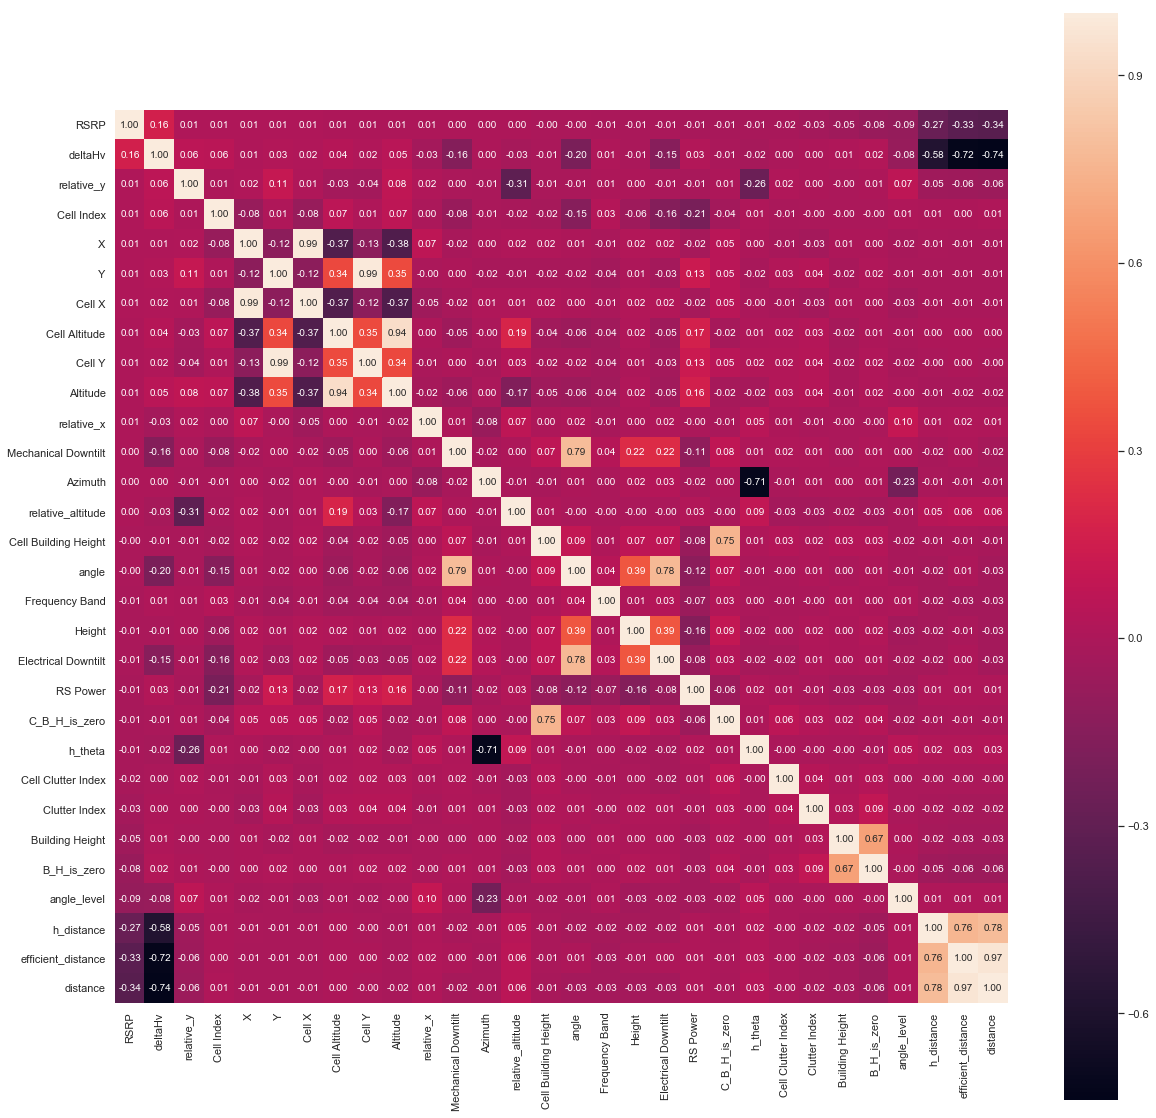

In [34]:
corrmat = data.corr()
fig = plt.figure(figsize=(20,20))
#correlation matrix
k = 31 #number of variables for heatmap
cols = corrmat.nlargest(k, 'RSRP')['RSRP'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [35]:
# new_data = data.drop(['Cell Index','Cell X', 'Cell Y','X', 'Y','relative_x', 'relative_y','Height', 
#                       'Electrical Downtilt', 'Mechanical Downtilt', 
#                       'angle','Azimuth','relative_altitude', 'Cell Building Height'], axis = 1)

In [36]:
# new_data.shape

In [37]:
# corrmat = new_data.corr()
# fig = plt.figure(figsize=(20,20))
# #correlation matrix
# k = 17 #number of variables for heatmap
# cols = corrmat.nlargest(k, 'RSRP')['RSRP'].index
# cm = np.corrcoef(new_data[cols].values.T)
# sns.set(font_scale=1)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

### 查看 distance 的箱线图
sns.boxplot(x="distance", y="RSRP", data=new_data.iloc[:10000,:])

In [ ]:
# new_data.head()

In [ ]:
# new_data.describe()

In [38]:
## 标准化
# from sklearn.preprocessing import StandardScaler
# import warnings
# warnings.filterwarnings("ignore")

# scaler = StandardScaler()
# scaler.fit(new_data['Altitude'].values.reshape(-1,1))
# new_data['Altitude_scaled'] = scaler.transform(new_data['Altitude'].values.reshape(-1,1))

# scaler.fit(new_data['Cell Altitude'].values.reshape(-1,1))
# new_data['Cell_Altitude_scaled'] = scaler.transform(new_data['Cell Altitude'].values.reshape(-1,1))

# scaler.fit(new_data['Building Height'].values.reshape(-1,1))
# new_data['Building_Height_scaled'] = scaler.transform(new_data['Building Height'].values.reshape(-1,1))

# scaler.fit(new_data['deltaHv'].values.reshape(-1,1))
# new_data['deltaHv_scaled'] = scaler.transform(new_data['deltaHv'].values.reshape(-1,1))
 
# scaler.fit(new_data['h_theta'].values.reshape(-1,1))
# new_data['h_theta_scaled'] = scaler.transform(new_data['h_theta'].values.reshape(-1,1))

# scaler.fit(new_data['angle_level'].values.reshape(-1,1))
# new_data['angle_level_scaled'] = scaler.transform(new_data['angle_level'].values.reshape(-1,1))
 
# new_data.drop(['Altitude','Cell Altitude','Building Height','deltaHv','h_theta','angle_level'], axis=1, inplace=True)
 
# new_data.head()

In [39]:
# new_data.shape

### onehot 编码

In [40]:
data_dummies_C_B_H = pd.get_dummies(data['C_B_H_is_zero'], prefix='C_B_H_is_zero')  
data_dummies_B_H = pd.get_dummies(data['B_H_is_zero'], prefix='B_H_is_zero')  
data_dummies_cell_clutter_index = pd.get_dummies(data['Cell Clutter Index'], prefix='Cell_Clutter_Index')  
data_dummies_clutter_index = pd.get_dummies(data['Clutter Index'], prefix='Clutter_Index')  
data_df = pd.concat([data, data_dummies_C_B_H,data_dummies_B_H, data_dummies_cell_clutter_index, data_dummies_clutter_index],axis =1)  

data_df.drop(['C_B_H_is_zero','B_H_is_zero','Cell Clutter Index', 'Clutter Index'], axis=1, inplace=True)  
data_df.head()  
#实验证明 Clutter Index onehot 对最后结果的影响不大

,Cell Index,Cell X,Cell Y,Height,Azimuth,Electrical Downtilt,Mechanical Downtilt,Frequency Band,RS Power,Cell Altitude,...,Clutter_Index_8,Clutter_Index_10,Clutter_Index_11,Clutter_Index_12,Clutter_Index_13,Clutter_Index_14,Clutter_Index_15,Clutter_Index_16,Clutter_Index_17,Clutter_Index_18
0,1001701,424515.0,3376325.0,1.380211,300,6,3,3.412461,16.2,504,...,0,0,0,0,0,0,1,0,0,0
1,1001701,424515.0,3376325.0,1.380211,300,6,3,3.412461,16.2,504,...,0,0,0,0,0,0,1,0,0,0
2,1001701,424515.0,3376325.0,1.380211,300,6,3,3.412461,16.2,504,...,0,0,0,0,0,0,0,0,0,0
3,1001701,424515.0,3376325.0,1.380211,300,6,3,3.412461,16.2,504,...,0,0,0,0,0,0,0,0,0,0
4,1001701,424515.0,3376325.0,1.380211,300,6,3,3.412461,16.2,504,...,0,0,0,0,0,0,0,0,0,0


In [41]:
test_dummies_C_B_H = pd.get_dummies(test['C_B_H_is_zero'], prefix='C_B_H_is_zero')  
test_dummies_B_H = pd.get_dummies(test['B_H_is_zero'], prefix='B_H_is_zero')  
test_dummies_cell_clutter_index = pd.get_dummies(test['Cell Clutter Index'], prefix='Cell_Clutter_Index')  
test_dummies_clutter_index = pd.get_dummies(test['Clutter Index'], prefix='Clutter_Index')  
test_df = pd.concat([test, test_dummies_C_B_H,test_dummies_B_H, test_dummies_cell_clutter_index, test_dummies_clutter_index],axis =1)  

test_df.drop(['C_B_H_is_zero','B_H_is_zero','Cell Clutter Index', 'Clutter Index'], axis=1, inplace=True)  
test_df.head()  

,Cell Index,Cell X,Cell Y,Height,Azimuth,Electrical Downtilt,Mechanical Downtilt,Frequency Band,RS Power,Cell Altitude,...,B_H_is_zero_0,B_H_is_zero_1,Cell_Clutter_Index_5,Clutter_Index_2,Clutter_Index_5,Clutter_Index_6,Clutter_Index_7,Clutter_Index_12,Clutter_Index_13,Clutter_Index_14
0,115001,414300.0,3391895.0,1.491362,200,9,6,3.412461,6.2,497,...,0,1,1,0,1,0,0,0,0,0
1,115001,414300.0,3391895.0,1.491362,200,9,6,3.412461,6.2,497,...,0,1,1,0,1,0,0,0,0,0
2,115001,414300.0,3391895.0,1.491362,200,9,6,3.412461,6.2,497,...,1,0,1,0,1,0,0,0,0,0
3,115001,414300.0,3391895.0,1.491362,200,9,6,3.412461,6.2,497,...,0,1,1,0,0,1,0,0,0,0
4,115001,414300.0,3391895.0,1.491362,200,9,6,3.412461,6.2,497,...,0,1,1,0,1,0,0,0,0,0


In [42]:
# data_dummies_C_B_H = pd.get_dummies(data['C_B_H_is_zero'], prefix='C_B_H_is_zero')
# data_dummies_B_H = pd.get_dummies(data['B_H_is_zero'], prefix='B_H_is_zero')
# data_df = pd.concat([data, data_dummies_C_B_H,data_dummies_B_H],axis =1)

# data_df.drop(['C_B_H_is_zero','B_H_is_zero'], axis=1, inplace=True)
# data_df.head()

In [43]:
# data_df.columns

corrmat = new_data.corr()
fig = plt.figure(figsize=(20,20))
correlation matrix
k = 19 #number of variables for heatmap
cols = corrmat.nlargest(k, 'RSRP')['RSRP'].index
cm = np.corrcoef(new_data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

data_df.to_csv("train/first_process.csv", index = False)

In [44]:
label = data_df['RSRP']

In [46]:
train = data_df.drop(['RSRP','trick'],axis = 1)
train.shape

(12011833, 56)

In [48]:
test = test_df
test.shape

(5011, 36)

In [49]:
#histogram and normal probability plot
# sns.distplot(train['RSRP']);
# fig = plt.figure()

In [50]:
data_df.columns

Index(['Cell Index', 'Cell X', 'Cell Y', 'Height', 'Azimuth',
       'Electrical Downtilt', 'Mechanical Downtilt', 'Frequency Band',
       'RS Power', 'Cell Altitude', 'Cell Building Height', 'X', 'Y',
       'Altitude', 'Building Height', 'RSRP', 'relative_x', 'relative_y',
       'distance', 'angle', 'relative_altitude', 'deltaHv', 'h_theta',
       'h_distance', 'angle_level', 'trick', 'efficient_distance',
       'C_B_H_is_zero_0', 'C_B_H_is_zero_1', 'B_H_is_zero_0', 'B_H_is_zero_1',
       'Cell_Clutter_Index_2', 'Cell_Clutter_Index_5', 'Cell_Clutter_Index_6',
       'Cell_Clutter_Index_7', 'Cell_Clutter_Index_8', 'Cell_Clutter_Index_10',
       'Cell_Clutter_Index_11', 'Cell_Clutter_Index_12',
       'Cell_Clutter_Index_13', 'Cell_Clutter_Index_14',
       'Cell_Clutter_Index_15', 'Cell_Clutter_Index_17',
       'Cell_Clutter_Index_18', 'Clutter_Index_2', 'Clutter_Index_5',
       'Clutter_Index_6', 'Clutter_Index_7', 'Clutter_Index_8',
       'Clutter_Index_10', 'Clutter_Index_

In [51]:
train.shape

(12011833, 56)

In [53]:
## 回归模型拟合
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

#models=[LinearRegression(),KNeighborsRegressor(),SVR(),Ridge(),Lasso(),MLPRegressor(alpha=20),DecisionTreeRegressor(),ExtraTreeRegressor(),XGBRegressor(),RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),BaggingRegressor()]
#models_str=['LinearRegression','KNNRegressor','SVR','Ridge','Lasso','MLPRegressor','DecisionTree','ExtraTree','XGBoost','RandomForest','AdaBoost','GradientBoost','Bagging']
models=[LinearRegression(),
        DecisionTreeRegressor()]
        #XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=10),
        #MLPRegressor(hidden_layer_sizes=(6,2),  activation='relu', solver='adam', alpha=0.0001),
        #RandomForestRegressor(),
        #AdaBoostRegressor(),
        #GradientBoostingRegressor(),
        #BaggingRegressor()]
models_str=['LinearRegression','DecisionTree','XGBoost','MLPRegressor','RandomForest','AdaBoost','GradientBoost','Bagging']
score_=[]

#x_train, x_test, y_train, y_test = train_test_split(train, label, test_size = 0.3, random_state = 1)

# for name,model in zip(models_str,models):
#     print('开始训练模型：'+name)
#     model=model   #建立模型
#     model.fit(x_train,y_train)
#     y_pred=model.predict(x_test)  
#     score=model.score(x_test,y_test)
#     score_.append(str(score)[:5])
#     print(name +' 得分:'+str(score))
model = DecisionTreeRegressor()   #建立模型
model.fit(train,label)
y_pred = model.predict(test)
# score = model.score(x_test,y_test)
# # score_.append(str(score)[:5])
# # print(name +' 得分:'+str(score))
# print(score)

ValueError: Number of features of the model must match the input. Model n_features is 56 and input n_features is 36 

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
print("MSE: ",mse)
print("RMSE: ",rmse)
print("MAE: ",mae)
print("R2: ",r2)

In [ ]:
def calculate_pcrr(y_true, y_pred):
    t = -103
    tp = len(y_true[(y_true < t) & (y_pred < t)])
    fp = len(y_true[(y_true >= t) & (y_pred < t)])
    fn = len(y_true[(y_true < t) & (y_pred >= t)])
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    pcrr = 2*(precision*recall)/(precision + recall)
    return pcrr
pcrr = calculate_pcrr(y_test,y_pred)  
print(pcrr)

#### 实验结果
DecisionTreeRegressor：  
pcrr: 0.6085233542012393  
MSE:  45.080667681286506  
RMSE:  6.714213854300927  
MAE:  4.628338424609066  
R2:  0.6070688989654098  
*********
pcrr: 0.6091614329605914   
MSE:  45.121796661736326  
RMSE:  6.717275985229156  
MAE:  4.628315777497192  
R2:  0.6067104114716835   